# Elevation Data Collection

In [1]:
data_folder = "../../data/raw/"
data_files = { 
    "fire_dz": "viirs-jpss1_2024_Algeria.csv",
    "fire_tn": "viirs-jpss1_2024_Tunisia.csv",
    "landcover_dz": "landcover_dz/dza_gc_adg.shp",
    "landcover_tn": "landcover_tn/tun_gc_adg.shp", 
    "landcover_legend": "landcover_dz/globcover_LCCS_legend_africa.xls",
    "climate_prec": "wc2.1_cruts4.09_5m_prec_2020-2024",
    "climate_tmax": "wc2.1_cruts4.09_5m_tmax_2020-2024",
    "climate_tmin": "wc2.1_cruts4.09_5m_tmin_2020-2024",
    "elevation": "be15_grd/be15_grd",
    "dz_boundaries": "gadm41_DZA_shp/gadm41_DZA_0.shp",
    "tn_boundaries": "gadm41_TUN_shp/gadm41_TUN_0.shp",
    "soil_bil": "HWSD2_RASTER/HWSD2.bil",
    "soil_csv": "HWSD2_DB/HWSD2_LAYERS.csv"
}

output_folder = "../../data/processed"
output_folders = {
    "fire": "fire",
    "landcover": "landcover",
    "climate": "climate",
    "elevation": "elevation",
    "soil": "soil"
}

In [2]:
import pandas as pd
import os
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import geopandas
import rasterio

## Helper Functions: Clip TN and DZ Data

In [3]:
### Loading and merging the boundaries of Algeria and Tunisia
def load_dz_tn_boundaries(dz_shapefile_path, tn_shapefile_path):
    dz = geopandas.read_file(dz_shapefile_path)
    tn = geopandas.read_file(tn_shapefile_path)

    # Ensure both shapefiles use the same CRS 
    if dz.crs != tn.crs:
        tn = tn.to_crs(dz.crs)

    # Concatenate the GeoDataFrames
    boundaries = geopandas.GeoDataFrame(pd.concat([dz, tn], ignore_index=True), crs=dz.crs)

    return boundaries

# Shapefile downloaded from https://gadm.org/
dz_boundaries_filepath = os.path.join(data_folder, data_files["dz_boundaries"])
tn_boundaries_filepath = os.path.join(data_folder, data_files["tn_boundaries"])

boundaries = load_dz_tn_boundaries(dz_boundaries_filepath, tn_boundaries_filepath)


def clip_instance(file, boundaries=boundaries):
    with rasterio.open(file) as src:
        # Clip raster with shapefile
        out_image, out_transform = mask(src, boundaries.geometry, crop=True)
        out_meta = src.meta.copy()
    
    # Update metadata
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    return out_image, out_meta

In [4]:
grid_path = os.path.join(data_folder, data_files["elevation"])  
with rasterio.open(grid_path) as src:
    print(src.driver)    
    print(src.width, src.height, src.shape)
    print(src.crs)
    print(src.bounds)
    arr = src.read(1) 
    print(arr.shape)

AIG
86400 33600 (33600, 86400)
EPSG:4326
BoundingBox(left=-180.00013888888893, bottom=-56.00013888888891, right=179.99986111111085, top=83.999861111111)
(33600, 86400)


In [5]:
img_elevation, meta_elevation = clip_instance(grid_path)

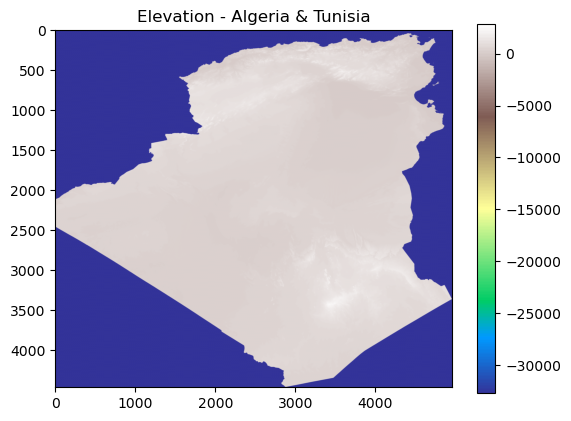

In [10]:
plt.imshow(img_elevation[0], cmap='terrain')
plt.title("Elevation - Algeria & Tunisia")
plt.colorbar()
plt.show()

In [7]:
output_base = os.path.join(output_folder, output_folders["elevation"])
os.makedirs(output_base, exist_ok=True)
output_filepath = os.path.join(output_base, "Elevation_DZ_TN.tif")
with rasterio.open(output_filepath, "w", **meta_elevation) as dest:
    dest.write(img_elevation)

print(f"Saved clipped raster to: {output_filepath}")

Saved clipped raster to: ../../data/processed/elevation/Elevation_DZ_TN.tif
